## Settings and Pointers

In [1]:
import sys 
sys.path.append('../../')

service_account_path = "../../creds/google__sa.json"
tracking_sheet_id = "1qBU7Kvuuij2fxbqPxebReKMxWgIBmOIE5Gi4ZuX0j_4"

In [2]:
import pandas as pd

from src.sheets_utils import download_sheet_as_df


contributors_df = download_sheet_as_df(
    service_account_path,
    tracking_sheet_id,
    "Contributors"
)

df = pd.concat(
    [
        download_sheet_as_df(
            service_account_path,
            tracking_sheet_id,
            "Conversations_Batch_2"
        ),
        download_sheet_as_df(
            service_account_path,
            tracking_sheet_id,
            "Conversations_Batch_3"
        ),
        download_sheet_as_df(
            service_account_path,
            tracking_sheet_id,
            "Conversations_Batch_4"
        ),
        download_sheet_as_df(
            service_account_path,
            tracking_sheet_id,
            "Conversations_Batch_5"
        ),
    ],
    ignore_index=True
)

df = df[df["completion_status"] == "Done"].reset_index()
df

,index,task_link,metadata__topic,assigned_to_email,completion_status,modified_question?,duration_mins,completion_date,comments,metadata__problem_type,metadata__target_length,review_status,reviewer_email,Team_Type(Internal/External),metadata__type
0,0,https://colab.research.google.com/drive/10cwJG...,python_language_and_scripting > functions_and_...,lucas.k@turing.com,Done,FALSE,13,12/21/2023,,query,1,done,test,External,NaN
1,1,https://colab.research.google.com/drive/16dCMc...,unit_testing_methodology > test_driven_develop...,ruturaj.m@turing.com,Done,TRUE,15,12/21/2023,,query,1,,,External,NaN
2,2,https://colab.research.google.com/drive/17KaqC...,python_language_and_scripting > decorators,ruturaj.m@turing.com,Done,FALSE,10,12/21/2023,,query,1,,,External,NaN
3,3,https://colab.research.google.com/drive/17mMiU...,algorithms > by_topic > bit_manipulation,daniel.oluwakayode-c@turing.com,Done,FALSE,20,12/20/2023,,query,1,,,External,NaN
4,4,https://colab.research.google.com/drive/18nl4l...,python_language_and_scripting > decorators,ruturaj.m@turing.com,Done,FALSE,10,12/21/2023,,modification,1,,,External,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2193,2742,https://colab.research.google.com/drive/1EmQ_Y...,Intermediate_Interview_preparation_User_asks_A...,kumbar.r@turing.com,Done,FALSE,95,1/7/2024,None,NaN,None,None,None,NaN,None
2194,2743,https://colab.research.google.com/drive/1tnJBH...,Intermediate_Interview_preparation_User_asks_A...,kumbar.r@turing.com,Done,FALSE,140,1/6/2024,"Interactive dashboard has been built ,takes fe...",NaN,None,None,None,NaN,None
2195,2744,https://colab.research.google.com/drive/1RMmB7...,Intermediate_Interview_preparation_User_asks_A...,kumbar.r@turing.com,Done,FALSE,125,1/6/2024,None,NaN,None,None,None,NaN,None
2196,2745,https://colab.research.google.com/drive/10tXpM...,Intermediate_Interview_preparation_User_asks_A...,kumbar.r@turing.com,Done,FALSE,120,1/6/2024,None,NaN,None,None,None,NaN,None


## Calculate number of turns

In [3]:
# Parse Conversations into list of dicts

import io
import threading

import nbformat
from fuzzywuzzy import fuzz

from google.oauth2 import service_account
from googleapiclient.discovery import build
from googleapiclient.http import MediaIoBaseDownload


def get_closest_match(query, choices):
    """
    Get the closest match(es) to a query string from a list of choices.

    :param query: The query string.
    :param choices: A list of strings to match against.
    :param limit: The maximum number of matches to return.
    """
    best_role = None
    best_score = 0
    for choice in choices:
        score = fuzz.ratio(query, choice)
        if score > best_score and score > 25:
            best_score = score
            best_role = choice

    return best_role, best_score


def notebook_parser(notebook):
    """
    Parse a notebook and extract the message objects.

    :param notebook: The notebook object.
    """
    messages = []
    for cell in notebook.cells[2:]:
        if cell["cell_type"] == "markdown":
            markdown_headers = ["**User**", "**Assistant**"]
            lines = cell["source"].split("\n")
            first_line = lines[0]
            role, score = get_closest_match(first_line, markdown_headers)
            if score>25:
                message = {
                    "role": role.replace("*", "").strip(),
                    "content": "\n".join(lines[1:]).strip("\n"),
                    "type": "markdown"
                }
                messages.append(message)

        elif cell["cell_type"] == "code":
            code_headers = ["# User", "# Assistant"]
            lines = cell["source"].split("\n")
            first_line = lines[0]
            role, score = get_closest_match(first_line, code_headers)
            if score>25:
                message = {
                    "role": role.replace("#", "").strip(),
                    "content": "\n".join(lines[1:]).strip("\n"),
                    "type": "code"
                }
                messages.append(message)
    return messages


def download_and_parse_notebook(service_account_file, file_id):
    # Authenticate with the service account
    credentials = service_account.Credentials.from_service_account_file(
        service_account_file, scopes=['https://www.googleapis.com/auth/drive'])
    service = build('drive', 'v3', credentials=credentials)

    # Request to download the file
    request = service.files().get_media(fileId=file_id)
    fh = io.BytesIO()
    downloader = MediaIoBaseDownload(fh, request)

    # Download the file
    done = False
    while not done:
        status, done = downloader.next_chunk()
        print("Download progress: %d%%." % int(status.progress() * 100))

    # Move the buffer's pointer to the beginning
    fh.seek(0)

    # Open the notebook
    notebook = nbformat.read(fh, as_version=4)

    # Parse the notebook
    messages = notebook_parser(notebook)

    # # Extract the first cell
    first_cell = notebook.cells[0]
    lines = first_cell["source"].split("\n")
    metadata = {}
    for line in lines:
        if "**Python Topics**" in line:
            metadata["topic"] = line.split(" - ")[1]
        if "**Type**" in line:
            metadata["type"] = line.split(" - ")[1]
        if "**Target Number of Turns (User + Assistant)**" in line:
            metadata["target_turns"] = line.split(" - ")[1]

    return {
        "id": file_id,
        "metadata": metadata,
        "messages":messages
    }


def threading_processor(service_account_path, file_id, results):
    results.append(download_and_parse_notebook(service_account_path, file_id))


threads = []
parsed_conversations = []
for i in range(df.shape[0]):
    file_id = df["task_link"][i].split("/")[-1]
    thread = threading.Thread(target=threading_processor, args=(service_account_path, file_id, parsed_conversations))
    threads.append(thread)
    thread.start()

for thread in threads:
    thread.join()


Download progress: 100%.
Download progress: 100%.
Download progress: 100%.
Download progress: 100%.
Download progress: 100%.
Download progress: 100%.
Download progress: 100%.
Download progress: 100%.
Download progress: 100%.
Download progress: 100%.
Download progress: 100%.
Download progress: 100%.
Download progress: 100%.
Download progress: 100%.
Download progress: 100%.
Download progress: 100%.
Download progress: 100%.
Download progress: 100%.
Download progress: 100%.
Download progress: 100%.
Download progress: 100%.
Download progress: 100%.
Download progress: 100%.
Download progress: 100%.
Download progress: 100%.
Download progress: 100%.
Download progress: 100%.
Download progress: 100%.
Download progress: 100%.
Download progress: 100%.
Download progress: 100%.
Download progress: 100%.
Download progress: 100%.
Download progress: 100%.
Download progress: 100%.
Download progress: 100%.
Download progress: 100%.
Download progress: 100%.
Download progress: 100%.
Download progress: 100%.


Exception in thread Thread-313:
Traceback (most recent call last):
  File "/home/joe96/miniconda3/lib/python3.9/threading.py", line 980, in _bootstrap_inner
    self.run()
  File "/home/joe96/miniconda3/lib/python3.9/threading.py", line 917, in run


Download progress: 100%.
Download progress: 100%.
Download progress: 100%.


    self._target(*self._args, **self._kwargs)
  File "/tmp/ipykernel_7047/2195223806.py", line 115, in threading_processor
  File "/tmp/ipykernel_7047/2195223806.py", line 83, in download_and_parse_notebook
  File "/home/joe96/projects/turing/character.ai/character_tasks/venv/lib/python3.9/site-packages/googleapiclient/_helpers.py", line 130, in positional_wrapper
    return wrapped(*args, **kwargs)
  File "/home/joe96/projects/turing/character.ai/character_tasks/venv/lib/python3.9/site-packages/googleapiclient/http.py", line 780, in next_chunk
    raise HttpError(resp, content, uri=self._uri)
googleapiclient.errors.HttpError: <HttpError 404 when requesting https://www.googleapis.com/drive/v3/files/1rfNQU__74pEdovonm_-u6yrhF0UsAa2C?alt=media returned "File not found: 1rfNQU__74pEdovonm_-u6yrhF0UsAa2C.". Details: "[{'message': 'File not found: 1rfNQU__74pEdovonm_-u6yrhF0UsAa2C.', 'domain': 'global', 'reason': 'notFound', 'location': 'fileId', 'locationType': 'parameter'}]">


Download progress: 100%.
Download progress: 100%.
Download progress: 100%.
Download progress: 100%.
Download progress: 100%.
Download progress: 100%.
Download progress: 100%.
Download progress: 100%.
Download progress: 100%.
Download progress: 100%.
Download progress: 100%.
Download progress: 100%.
Download progress: 100%.
Download progress: 100%.
Download progress: 100%.
Download progress: 100%.
Download progress: 100%.
Download progress: 100%.
Download progress: 100%.
Download progress: 100%.
Download progress: 100%.
Download progress: 100%.
Download progress: 100%.
Download progress: 100%.
Download progress: 100%.
Download progress: 100%.
Download progress: 100%.
Download progress: 100%.
Download progress: 100%.
Download progress: 100%.
Download progress: 100%.
Download progress: 100%.
Download progress: 100%.
Download progress: 100%.
Download progress: 100%.Download progress: 100%.

Download progress: 100%.
Download progress: 100%.
Download progress: 100%.
Download progress: 100%.


Exception in thread Thread-311:
Traceback (most recent call last):
  File "/home/joe96/miniconda3/lib/python3.9/threading.py", line 980, in _bootstrap_inner
    self.run()
  File "/home/joe96/miniconda3/lib/python3.9/threading.py", line 917, in run
    self._target(*self._args, **self._kwargs)
  File "/tmp/ipykernel_7047/2195223806.py", line 115, in threading_processor


Download progress: 100%.
Download progress: 100%.
Download progress: 100%.
Download progress: 100%.
Download progress: 100%.
Download progress: 100%.


  File "/tmp/ipykernel_7047/2195223806.py", line 83, in download_and_parse_notebook
  File "/home/joe96/projects/turing/character.ai/character_tasks/venv/lib/python3.9/site-packages/googleapiclient/_helpers.py", line 130, in positional_wrapper
    return wrapped(*args, **kwargs)
  File "/home/joe96/projects/turing/character.ai/character_tasks/venv/lib/python3.9/site-packages/googleapiclient/http.py", line 780, in next_chunk


Download progress: 100%.
Download progress: 100%.
Download progress: 100%.
Download progress: 100%.


    raise HttpError(resp, content, uri=self._uri)
googleapiclient.errors.HttpError: <HttpError 404 when requesting https://www.googleapis.com/drive/v3/files/1lHYB-8JiU67LlaqjvaRuLYUbetxWbnD5%23scrollTo%3DvzyhtIq2Tt8Q?alt=media returned "File not found: 1lHYB-8JiU67LlaqjvaRuLYUbetxWbnD5#scrollTo=vzyhtIq2Tt8Q.". Details: "[{'message': 'File not found: 1lHYB-8JiU67LlaqjvaRuLYUbetxWbnD5#scrollTo=vzyhtIq2Tt8Q.', 'domain': 'global', 'reason': 'notFound', 'location': 'fileId', 'locationType': 'parameter'}]">


Download progress: 100%.
Download progress: 100%.
Download progress: 100%.
Download progress: 100%.
Download progress: 100%.
Download progress: 100%.
Download progress: 100%.
Download progress: 100%.
Download progress: 100%.
Download progress: 100%.
Download progress: 100%.
Download progress: 100%.
Download progress: 100%.
Download progress: 100%.
Download progress: 100%.
Download progress: 100%.
Download progress: 100%.
Download progress: 100%.
Download progress: 100%.
Download progress: 100%.
Download progress: 100%.
Download progress: 100%.
Download progress: 100%.
Download progress: 100%.
Download progress: 100%.
Download progress: 100%.
Download progress: 100%.
Download progress: 100%.
Download progress: 100%.
Download progress: 100%.
Download progress: 100%.
Download progress: 100%.
Download progress: 100%.
Download progress: 100%.
Download progress: 100%.
Download progress: 100%.
Download progress: 100%.
Download progress: 100%.
Download progress: 100%.
Download progress: 100%.


## Visualize distribution of dataset
- Top Level Topic
- Number of Turns
- Internal vs Anthropic vs Dedicated
- Daily Trends by Team
- Daily Trends by Turns

In [5]:
from datetime import datetime

def get_number_of_turns(messages):

    initial_role = messages[0]["role"]

    count = 0
    for message in messages:
        if message["role"] == initial_role:
            count += 1
    return count


def standardize_date_format(date):
    """
    Given a date string, standardize the date format to YYYY/MM/DD.
    """
    if date is None:
        return ""
    try:
        # Parse the date string into a datetime object
        standardized_date = datetime.strptime(date, "%Y/%m/%d")
    except ValueError:
        try:
            # Attempt to parse other common formats here
            # Example: MM/DD/YYYY
            standardized_date = datetime.strptime(date, "%m/%d/%Y")
        except ValueError:
            return "Invalid date format"

    # Format the datetime object into the desired string format
    return standardized_date.strftime("%Y/%m/%d")


metadata_only = []
for conversation in parsed_conversations:
    
    # Extract actual number of turns
    conversation["metadata"]["actual_turns"] = get_number_of_turns(conversation["messages"])

    try:
        tracking_record = df[df["task_link"].str.contains(conversation["id"])].iloc[0].to_dict()
    except IndexError:
        print("IndexError for id:", conversation["id"])
        continue

    # Get Author email
    conversation["metadata"]["assigned_to_email"] = tracking_record["assigned_to_email"]

    # Get duration
    conversation["metadata"]["duration_mins"] = tracking_record["duration_mins"]

    # Get Completion Date
    conversation["metadata"]["completion_date"] = standardize_date_format(tracking_record["completion_date"])

    # Get Team
    try:
        conversation["metadata"]["team"] = contributors_df[contributors_df["Email"] == tracking_record["assigned_to_email"]].iloc[0]["Source"]
    except IndexError:
        print("IndexError for email:", tracking_record["assigned_to_email"])
        conversation["metadata"]["team"] = "Unknown"

    metadata_only.append(conversation["metadata"])

IndexError for email: https://colab.research.google.com/drive/1s6QrFchojtSInYl0xrwJ-Dcv6gqqL8lB
IndexError for email: raman.k@turing.com
IndexError for email: 
IndexError for email: satya.s@turing.com
IndexError for email: satya.s@turing.com
IndexError for email: andranik.g@gmail.com
IndexError for email: raman.k@turing.com
IndexError for email: shaharyar.t@turing.com
IndexError for email: toh.y@turing,com
IndexError for email: andranik.g@gmail.com
IndexError for email: 
IndexError for email: raman.k@turing.com
IndexError for email: toh.y@turing,com


In [6]:
metadata_only_df = pd.DataFrame(metadata_only)
metadata_only_df

,topic,type,target_turns,actual_turns,assigned_to_email,duration_mins,completion_date,team
0,algorithms > by_data_structure > heaps,query,1,1,afnan.baig@turing.com,10,2023/12/20,Internal
1,algorithms > by_topic > math,modification,1,1,lucas.k@turing.com,12,2023/12/21,Anthropic
2,algorithms > by_topic > geometry,modification,1,1,james.oladimeji-c@turing.com,15,2023/12/20,Cross Clients
3,algorithms > by_topic > statistics,query,1,1,yuzhao.ni@turing.com,10,2023/12/19,Internal
4,algorithms > by_topic > bit_manipulation,query,1,1,daniel.oluwakayode-c@turing.com,20,2023/12/20,Cross Clients
...,...,...,...,...,...,...,...,...
2191,NaN,NaN,1-5,11,kumbar.r@turing.com,90,2024/01/05,Vetting
2192,data_analysis > data_grouping_aggregation,modification,3,3,jha.r@turing.com,20,2023/12/29,Vetting
2193,NaN,NaN,1-5,6,kumbar.r@turing.com,75,2024/01/05,Vetting
2194,algorithms > by_topic > famous_algorithms,query,1,1,ruturaj.m@turing.com,15,2023/12/25,Anthropic


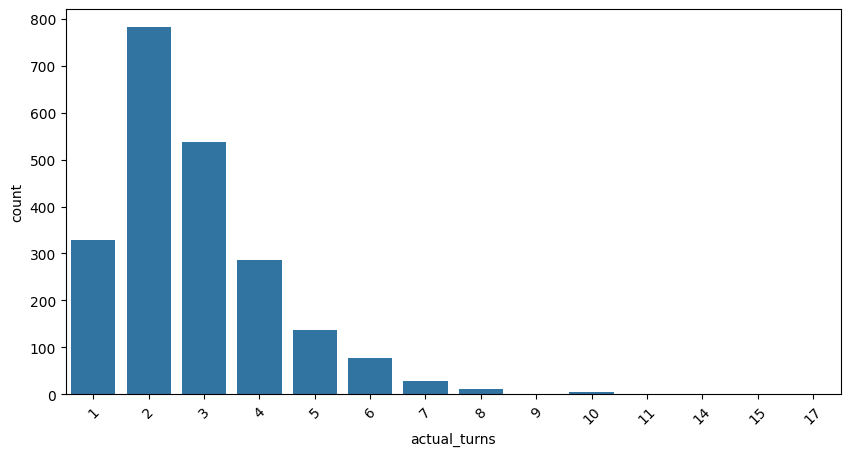

In [7]:
# Visualize Convo Length
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 5))
sns.countplot(data=metadata_only_df, x="actual_turns")
plt.xticks(rotation=45)
plt.show()



In [10]:
import plotly.express as px
import pandas as pd

# Assuming you have the 'metadata_only_df' DataFrame with 'completion_date' column
# First, ensure that the 'completion_date' column is in datetime format


metadata_only_df["completion_date"] = metadata_only_df["completion_date"].replace("Invalid date format", "")
metadata_only_df["completion_date"] = pd.to_datetime(metadata_only_df["completion_date"], errors='coerce')

# Convert the 'completion_date' to string for better compatibility with Plotly
metadata_only_df["completion_date_str"] = metadata_only_df["completion_date"].dt.strftime('%Y-%m-%d')

start_date = '2024-01-01'
end_date = '2024-01-08'
filtered_df = metadata_only_df[(metadata_only_df['completion_date'] >= start_date) & (metadata_only_df['completion_date'] <= end_date)]

# Grouping by the completion date to get the count for each date
date_counts = filtered_df['completion_date_str'].value_counts().reset_index()
date_counts.columns = ['completion_date', 'count']

# Creating the plot using Plotly
fig = px.bar(date_counts, x='completion_date', y='count', title='Completion Date Counts')
fig.update_xaxes(tickangle=45)
fig.show()


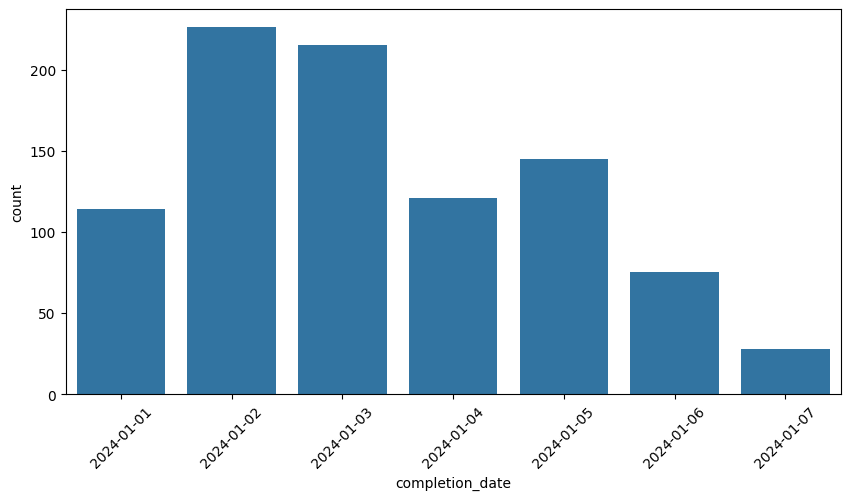

In [11]:
# Visualize Trend over time
plt.figure(figsize=(10, 5))
metadata_only_df["completion_date"] = metadata_only_df["completion_date"].replace("Invalid date format", "")
metadata_only_df["completion_date"] = pd.to_datetime(metadata_only_df["completion_date"], format="mixed")
sns.countplot(data=filtered_df, x="completion_date")
plt.xticks(rotation=45)
plt.show()

- Top Level Topic
- Number of Turns
- Internal vs Anthropic vs Dedicated
- Daily Trends by Team
- Daily Trends by Turns

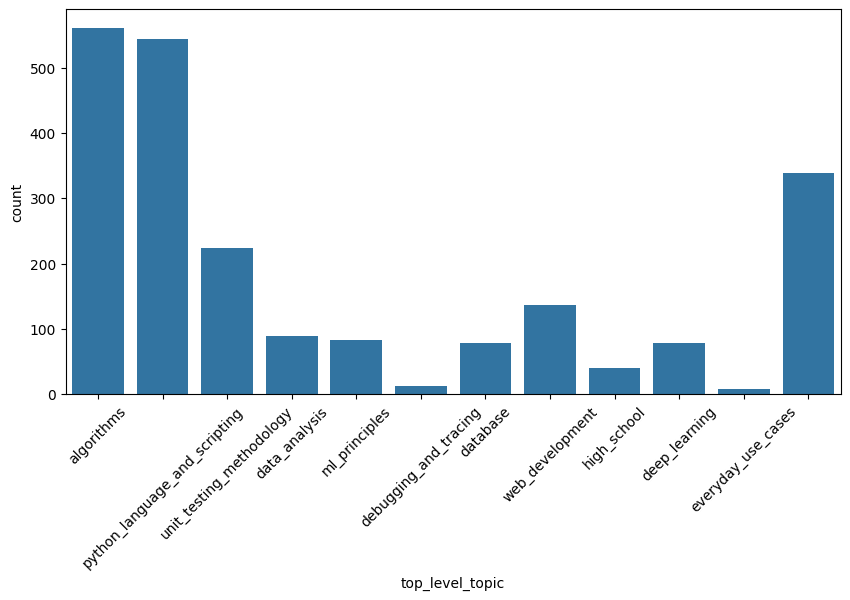

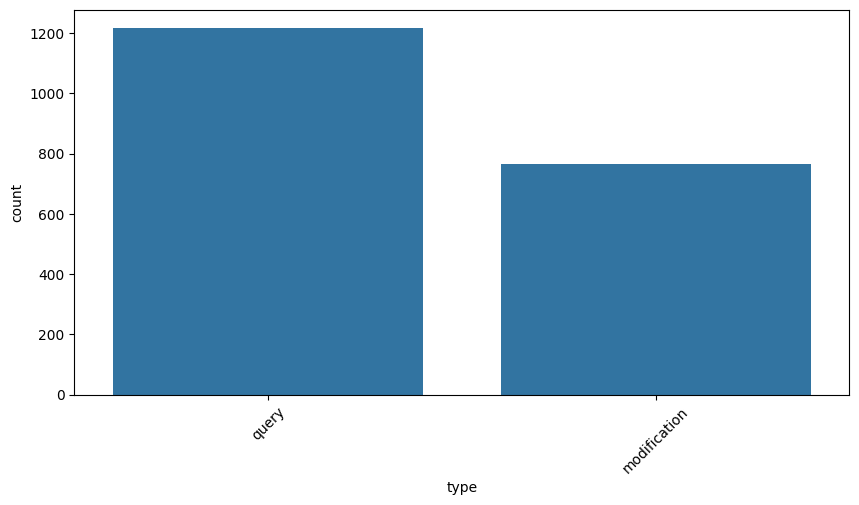

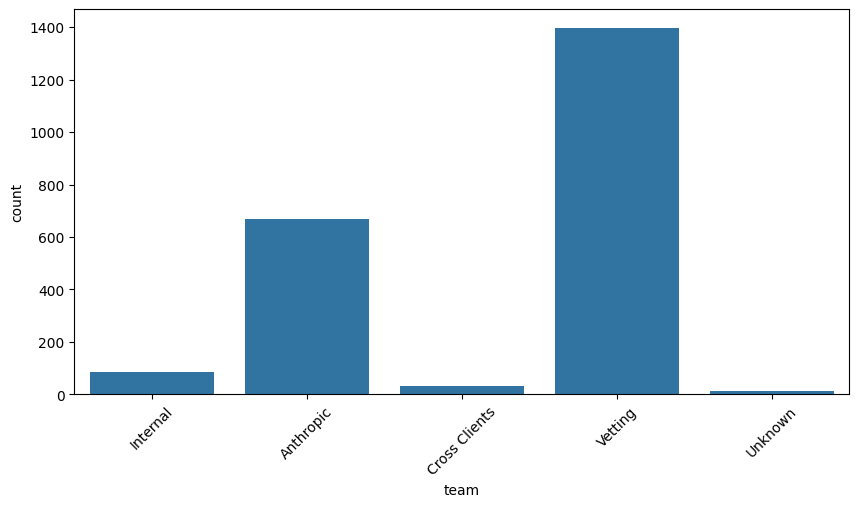

In [12]:
metadata_only_df["top_level_topic"] = metadata_only_df["topic"].fillna("").apply(lambda x: x.split(" > ")[0])
plt.figure(figsize=(10, 5))
sns.countplot(data=metadata_only_df, x="top_level_topic")
plt.xticks(rotation=45)

plt.figure(figsize=(10, 5))
sns.countplot(data=metadata_only_df, x="type")
plt.xticks(rotation=45)

plt.figure(figsize=(10, 5))
sns.countplot(data=metadata_only_df, x="team")
plt.xticks(rotation=45)

plt.show()

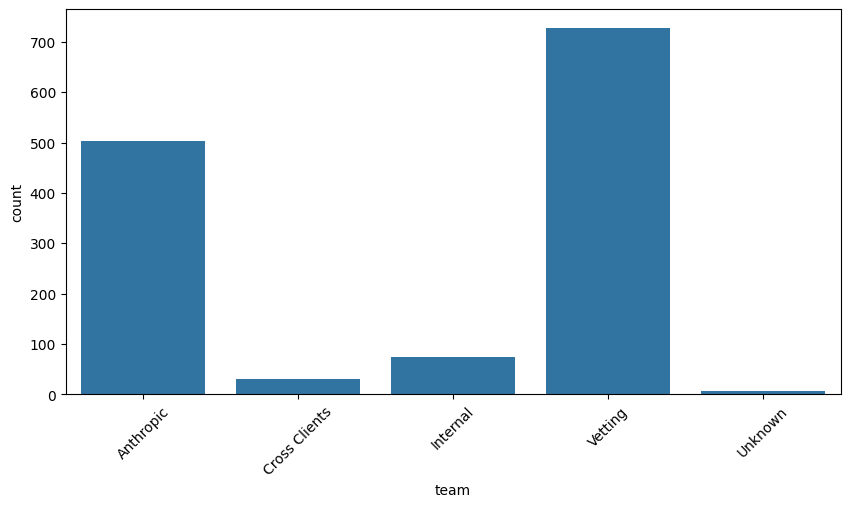

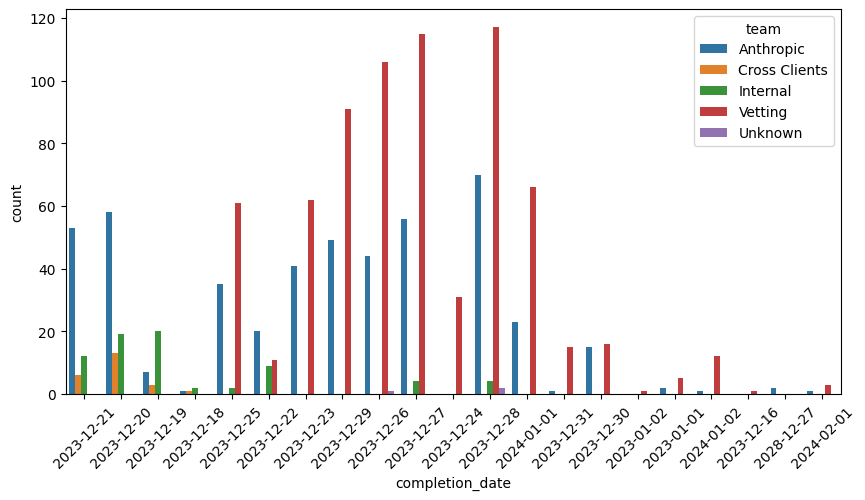

In [17]:
# Breakdown by team (2 subplots; 1 for totals, 1 for trendline by completion_date)
plt.figure(figsize=(10, 5))
sns.countplot(data=metadata_only_df, x="team")
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(10, 5))
sns.countplot(data=metadata_only_df, x="completion_date", hue="team")
plt.xticks(rotation=45)
plt.show()